# Environment Settings

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fmin
import math

In [2]:

from matplotlib import pyplot as plt
from IPython.display import display, HTML, clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 500)

# Question I: Pricing
Our marketing manager was surveying the willingness to buy one of our fashion items at a certain price. They discovered the demand quantities, i.e. the number of people willing to buy, at various price levels. We have them below in two arrays.

Please find out the optimal price that maximises revenue.

**Hint**: our two different methods place the answer between 25 and 50. We are more interested in your approach, methods and code than getting an exact answer for this part.

The supplier for this particular fashion item has applied progressive discounting on their price. This means that quantities of the item above a certain value cost progressively less than the initial quantities. This is their pricing table:

| quantity | supplier price | 
|:-----------|-----------------:|
| <= 50 | 15 | 
|51-100 | 12 | 
|101-200 | 8| 
|>200 | 4|

Knowing the demand (from the previous question) and the supplier price, and assuming that the only costs we have are the cost of the goods we sell, please find the price that maximizes our profits.

In [3]:
pricing = pd.DataFrame({
'prices': [100, 90, 70, 60, 40, 20, 10],
'demand': [100, 120, 200, 300, 1200, 2000, 2800] })


## Approach 1: Direct Estimate

+ Use pandas dataframe to find out the according price with the `max(revenue)` where `revenue = prices * demand`

In [4]:
def revenue_maximizing_price(prices, demand)->float: 
    ''' Estimate the revenue maximizing price with input dataframe.
    
    Input
    -----
    # prices: input prices as pd series
    # demand: input demand as pd series
    
    Output
    ------
    # output: revenue_max price
    '''

    revenue = pd.Series(prices * demand, name='revenue')
    new_df = pd.concat([prices, demand, revenue], axis=1)

    return(new_df.loc[new_df['revenue'].argmax(), 'prices'])

In [5]:
print('The price with max revenue is {}.'.format(revenue_maximizing_price(pricing.prices, pricing.demand)))

The price with max revenue is 40.


### Create supplier dataframe

In [6]:
df_supplier = pd.DataFrame([15, 12, 8, 4], columns=['supplier_price'])
df_supplier['quantity'] = [pd.Interval(left=0, right=50),
                           pd.Interval(left=50, right=100),
                           pd.Interval(left=100, right=200),
                           pd.Interval(left=200, right=5000)]
df_supplier

,supplier_price,quantity
0,15,"(0, 50]"
1,12,"(50, 100]"
2,8,"(100, 200]"
3,4,"(200, 5000]"


In [7]:
def profit_maximizing_price(df_pricing, df_cost)->float:
    ''' Estimate the profit maximizing price with input dataframe.

    Input
    -----
    df_pricing: input prices as pd dataframe
    df_cost: input cost as pd dataframe

    Output
    ------
    output: profit_max price and final dataframe
    '''

    pricing_cost = pd.merge(df_pricing, df_cost, how="cross")
    pricing_cost = pricing_cost[pricing_cost.apply(lambda x: x.demand in x.quantity, axis=1)].reset_index()
    pricing_cost['profit'] = (pricing_cost.prices - pricing_cost.supplier_price) * pricing_cost.demand

    return(pricing_cost.loc[pricing_cost['profit'].argmax(), 'prices'], pricing_cost)    

In [8]:
print('The price with max profit is {}.'.format(profit_maximizing_price(pricing, df_supplier)[0]))


The price with max profit is 40.


## Approach II: Interpolating for more data points

Fill the gap of sparse data points to have more estimatations. Here we use the **polynomial** function for the calculation.

,prices,demand
0,10.0,2800.000000
1,20.0,2000.000000
2,30.0,1549.752066
3,40.0,1200.000000
4,50.0,701.487603
5,60.0,300.000000
6,70.0,200.000000
7,80.0,153.553719
8,90.0,120.000000
9,100.0,100.000000


<Axes: >

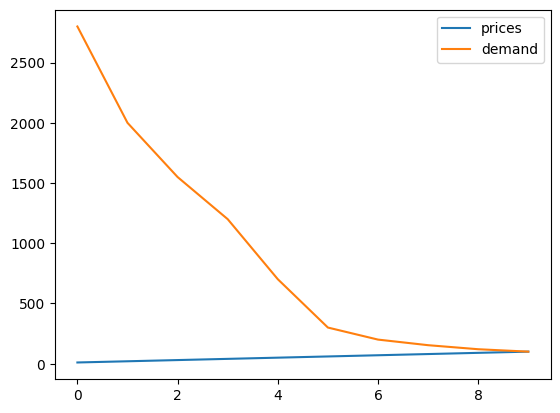

In [9]:
pricing_inter = pricing.copy()
pricing_inter.loc[-1, 'prices'] = 30
pricing_inter.loc[-2, 'prices'] = 50
pricing_inter.loc[-3, 'prices'] = 80
pricing_inter = pricing_inter.sort_values('prices').reset_index(drop=True)
pricing_inter.interpolate(method='polynomial', order=2, inplace=True)
pricing_inter
pricing_inter.plot()

In [10]:
print('The price with max revenue is {}.'.format(revenue_maximizing_price(pricing_inter.prices, pricing_inter.demand)))
print('The price with max profit is {}.'.format(profit_maximizing_price(pricing_inter, df_supplier)))


The price with max revenue is 40.0.
The price with max profit is (40.0,    index  prices       demand  supplier_price     quantity        profit
0      3    10.0  2800.000000               4  (200, 5000]  16800.000000
1      7    20.0  2000.000000               4  (200, 5000]  32000.000000
2     11    30.0  1549.752066               4  (200, 5000]  40293.553719
3     15    40.0  1200.000000               4  (200, 5000]  43200.000000
4     19    50.0   701.487603               4  (200, 5000]  32268.429752
5     23    60.0   300.000000               4  (200, 5000]  16800.000000
6     26    70.0   200.000000               8   (100, 200]  12400.000000
7     30    80.0   153.553719               8   (100, 200]  11055.867769
8     34    90.0   120.000000               8   (100, 200]   9840.000000
9     37   100.0   100.000000              12    (50, 100]   8800.000000).


+ The interpolated dataframe showes the same results

## Approach III: data points fitting

+ Fitting the input data points with **polynomial** function and find out the corresponding price when maximizing the demand and profit

In [11]:
def price_fitting(x, y, order, input_range, file_path):
    ''' Polynomial data point fitting

    Input
    -----
    x, y: (x, y) data points arrays
    order: polynomial order to be fit
    input_range: x range for plotting
    file_path: path to save the figure

    Output
    ------
    max_value: max y in the polynomial function

    '''
    
    coefficients, res = np.polyfit(x, y, order, full=True)[0:2]
    f = np.poly1d(coefficients)
    rmse = (res / len(x)) ** 0.5

    def find_x_from_y(x, y, order, value, threshold=1E-6):
        # subtract the y value, fit a polynomial, then find the roots of it
        r = np.roots(np.polyfit(x, y - value, order))

        # return only the real roots.. due to numerical errors, you
        # must introduce a threshold value to its complex part.
        output = r.real[abs(r.imag) < threshold]
        return np.sort(output[ output < max(x) ])

    fig, ax = plt.subplots()

    plt.plot(input_range, f(input_range))
    plt.plot(x, y)
    plt.title(np.poly1d(coefficients), fontsize=8)
    max_value = np.argmax(f(input_range))
    plt.axhline(y=f(max_value) - rmse, color='r', linestyle='dotted')
    max_range = find_x_from_y(x, y, order, f(max_value) - rmse, 1E-8)
    ax.legend(['polynomial order of {}'.format(order),'real data'])
    ax.set_xlabel(x.name, fontsize=12)
    ax.set_ylabel(y.name, fontsize=12)
    fig.savefig(file_path, dpi=300)

    return(max_value, rmse, max_range)

The price with max revenue is 29 witm RMSE of 3810.5 
and the max range are between 20.4 and 40.7.


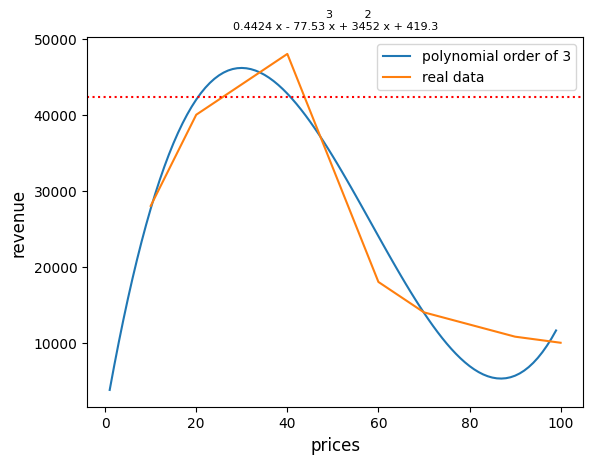

In [12]:
pricing['revenue'] = pricing.prices * pricing.demand
max_revenue_price, rmse, max_range = price_fitting(pricing.prices, pricing.revenue, 3, range(1, 100), 'img/revenue_max.png')
print('The price with max revenue is {} witm RMSE of {:.1f} \nand the max range are between {:.1f} and {:.1f}.'.format(max_revenue_price, *rmse, *max_range))


The price with max profit is 32 witm RMSE of 3528.2 
and the max range are between 23.3 and 43.2.


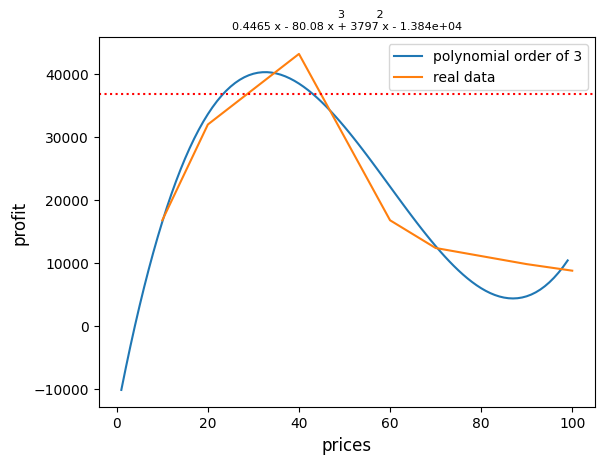

In [13]:
# Using the function defined above
_, pricing_cost = profit_maximizing_price(pricing, df_supplier)
max_profit_price, rmse, max_range  = price_fitting(pricing_cost.prices, pricing_cost.profit, 3, range(1, 100), 'img/profit_max.png')
print('The price with max profit is {} witm RMSE of {:.1f} \nand the max range are between {:.1f} and {:.1f}.'.format(max_profit_price, *rmse, *max_range))


## Discussions

+ Both revenue-max and profit-max prices from the fitting data are lower than the direct calculations (i.e, 29 vs. 40 and 32 vs. 40)
+ Curve fitting can have error estimates with bigger flexibility in the business sense
+ Sometimes there will probably no sweet spots for local min/max. In those cases, extra attributes, e.g., other costs, time comsumptions, or promotions, etc., are needed for optimizations.
+ Further Improvement
    + Uncertaintiy range can be better estimated with the boosting sampling